In [1]:
import tributary as t
import pyEX as p
import pandas as pd

In [2]:
def sma_close(data):
    dat = [x['close'] for x in data]
    return sum(dat)/len(dat)
    
def crosses(state, data):
    sma_short = data[0]
    sma_long = data[1]

    if state.golden:
        # short moved above long
        if sma_short < sma_long:
            state.golden = False
    else:
        # long moved above short
        if sma_short > sma_long:
            state.golden = True
            
    # clean output data
    data = data[2]
    data['sma_short'] = sma_short
    data['sma_long'] = sma_long
    return data

In [3]:
def wrap(ticker):
    # data source
    data = t.Delay(t.UnrollDataFrame(p.Client(version="sandbox").chartDF(ticker, '3m')), .05)

    # windows
    window1 = t.Window(data, size=3, full_only=False)
    window2 = t.Window(data, size=20, full_only=False)

    # avgs
    sma1 = t.Apply(sma_close, window1)
    sma2 = t.Apply(sma_close, window2)

    # merge streams
    merged = t.Reduce(sma1, sma2, data)

    calc = t.Apply(t.State(crosses, golden=False), merged)
    # psp = t.Print(calc)
    psp = t.Perspective(calc, columns=['close', 'sma_short', 'sma_long'], view='y_line', rowpivots=['index'])
    return psp

In [4]:
run = []

# AAPL

In [5]:
run.append(wrap('aapl'))

PerspectiveWidget(columns=['close', 'sma_short', 'sma_long'], datasrc='list', rowpivots=['index'], view='y_lin…

# IBM

In [6]:
run.append(wrap('ibm'))

PerspectiveWidget(columns=['close', 'sma_short', 'sma_long'], datasrc='list', rowpivots=['index'], view='y_lin…

# TSLA 

In [7]:
run.append(wrap('tsla'))

PerspectiveWidget(columns=['close', 'sma_short', 'sma_long'], datasrc='list', rowpivots=['index'], view='y_lin…

In [8]:
def correlation(state, data):
    if state.dat is None:
        state.dat = []
    new = {s: data[i]['changePercent'] for i, s in enumerate(state.symbols)}
    state.dat.append(new)
    df = pd.DataFrame(state.dat)
    return df.corr()

reduced = t.Reduce(*run)
final = t.Perspective(t.Apply(t.State(correlation, dat=None, symbols=['aapl', 'ibm', 'tsla']), reduced), view='heatmap', columns=['aapl', 'ibm', 'tsla'], rowpivots=['index'], aggregates={'aapl':'last', 'ibm': 'last', 'tsla': 'last'})

PerspectiveWidget(aggregates={'aapl': 'last', 'ibm': 'last', 'tsla': 'last'}, columns=['aapl', 'ibm', 'tsla'],…

In [9]:
t.run(final)

[      aapl  ibm  tsla
 aapl   NaN  NaN   NaN
 ibm    NaN  NaN   NaN
 tsla   NaN  NaN   NaN,       aapl  ibm  tsla
 aapl   1.0  1.0   1.0
 ibm    1.0  1.0   1.0
 tsla   1.0  1.0   1.0,           aapl       ibm      tsla
 aapl  1.000000  0.732113 -0.399760
 ibm   0.732113  1.000000  0.331716
 tsla -0.399760  0.331716  1.000000,           aapl       ibm      tsla
 aapl  1.000000  0.452141 -0.399497
 ibm   0.452141  1.000000 -0.611403
 tsla -0.399497 -0.611403  1.000000,           aapl       ibm      tsla
 aapl  1.000000  0.482871 -0.202718
 ibm   0.482871  1.000000 -0.355255
 tsla -0.202718 -0.355255  1.000000,           aapl       ibm      tsla
 aapl  1.000000  0.574576  0.551773
 ibm   0.574576  1.000000  0.126991
 tsla  0.551773  0.126991  1.000000,           aapl       ibm      tsla
 aapl  1.000000 -0.074515  0.518732
 ibm  -0.074515  1.000000 -0.004574
 tsla  0.518732 -0.004574  1.000000,           aapl       ibm      tsla
 aapl  1.000000  0.065561 -0.125455
 ibm   0.065561  1.00000

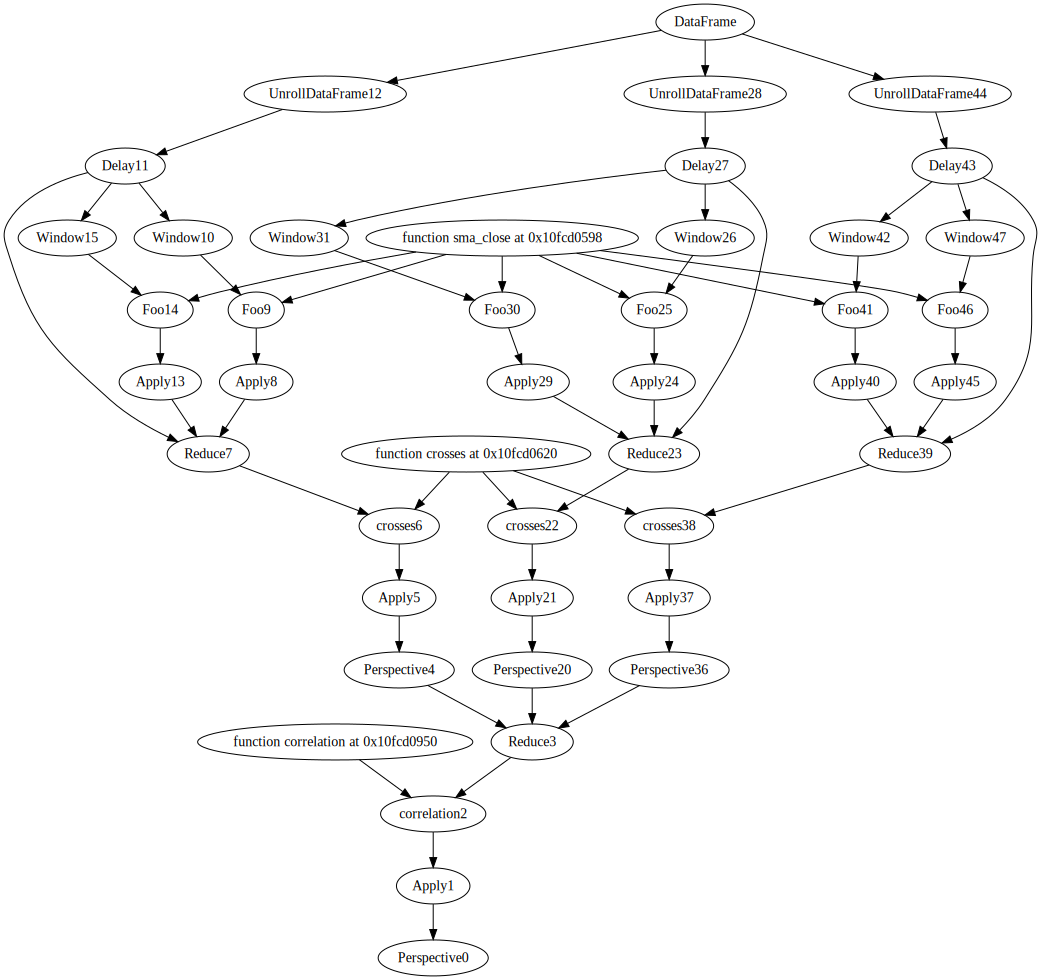

In [10]:
t.GraphViz(final)